In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 as cv

import random
from sklearn.metrics import classification_report, confusion_matrix
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate, AveragePooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os


In [2]:
# create dictionary of relationship between label and sign
categories = {0:"1", 1: "2", 2:"3", 3:"A", 4: "C", 5: "L", 6: "OK",7: "SMILE", 8: "YO"}

In [3]:
# create dataframe from images in directory
data_path = 'ds'
root_dir = os.listdir(data_path)
file_list = []
image_list = []
label_list = []

for directory in root_dir:
    directory_path = f"{data_path}/{directory}"
    if not os.path.isdir(directory_path) or directory=='ds':
        continue
    for files in os.listdir(f"{data_path}/{directory}"):
        file_path = f"{data_path}/{directory}/{files}"
        file_list.append(file_path)
        label_list.append(directory)
        img = imread(file_path)
        image_list.append(np.array(img))
df = pd.DataFrame({'file':file_list,'image':image_list,'label':label_list})
df

,file,image,label
0,ds/1/1.jpg,"[[183, 182, 181, 181, 182, 182, 182, 181, 182,...",1
1,ds/1/10.jpg,"[[172, 172, 172, 172, 173, 173, 173, 173, 174,...",1
2,ds/1/100.jpg,"[[173, 173, 173, 173, 174, 174, 174, 174, 175,...",1
3,ds/1/1000.jpg,"[[150, 148, 147, 146, 146, 147, 146, 142, 141,...",1
4,ds/1/1001.jpg,"[[150, 147, 146, 149, 146, 149, 143, 141, 140,...",1
...,...,...,...
25195,ds/YO/995.jpg,"[[142, 135, 132, 124, 109, 105, 121, 141, 143,...",YO
25196,ds/YO/996.jpg,"[[140, 132, 130, 118, 107, 108, 138, 143, 142,...",YO
25197,ds/YO/997.jpg,"[[143, 139, 131, 130, 112, 104, 108, 136, 144,...",YO
25198,ds/YO/998.jpg,"[[140, 135, 131, 124, 104, 106, 122, 144, 142,...",YO


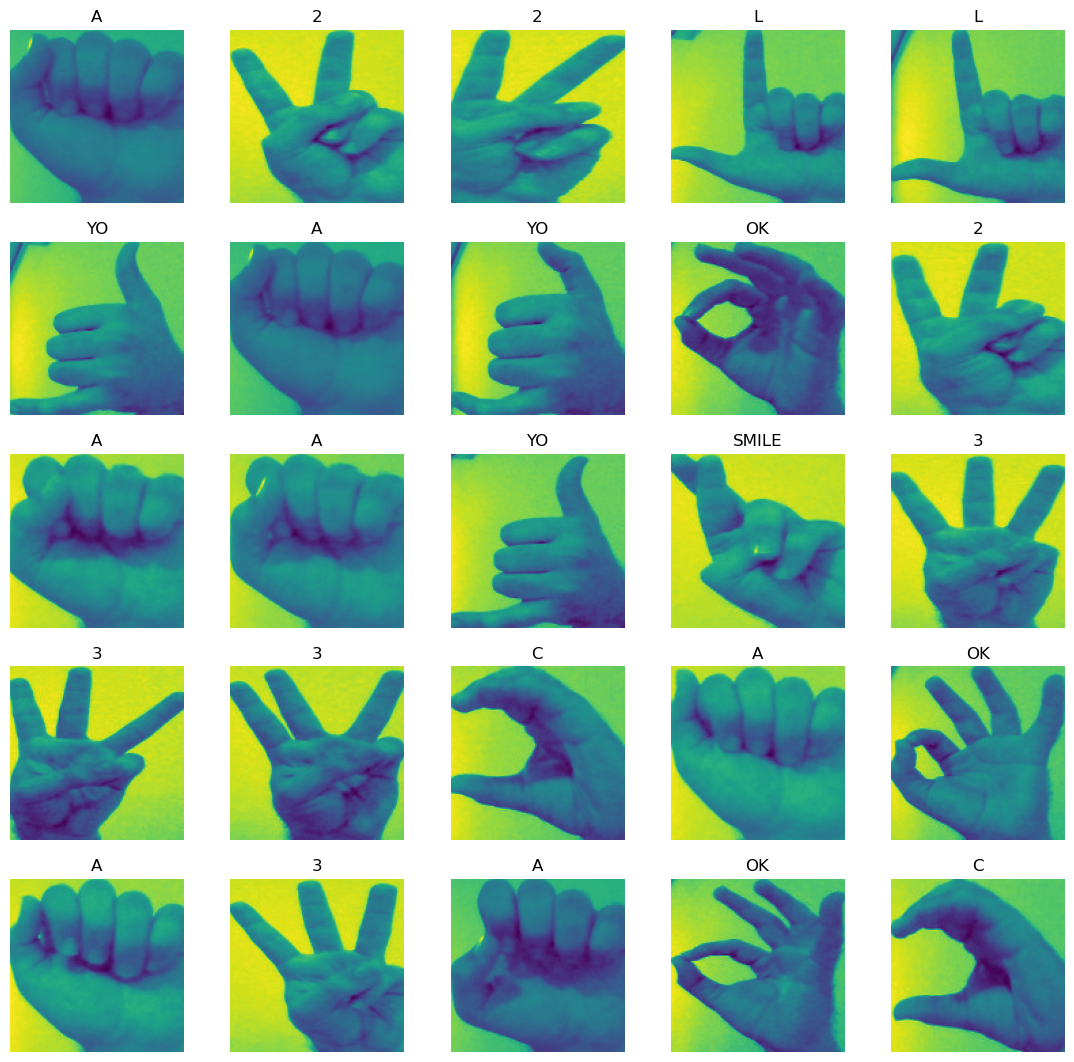

In [4]:
# visualize data
plt.figure(figsize=(11,11))
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    plt.axis('off')
    randval = random.choice(list(categories.values()))
    randimg = imread(data_path + '/' + randval + '/' + random.choice(sorted(os.listdir(data_path + '/' + randval + '/'))))
    plt.imshow(randimg)
    plt.title(randval)

Text(0.5, 1.0, 'Count of Images by Sign')

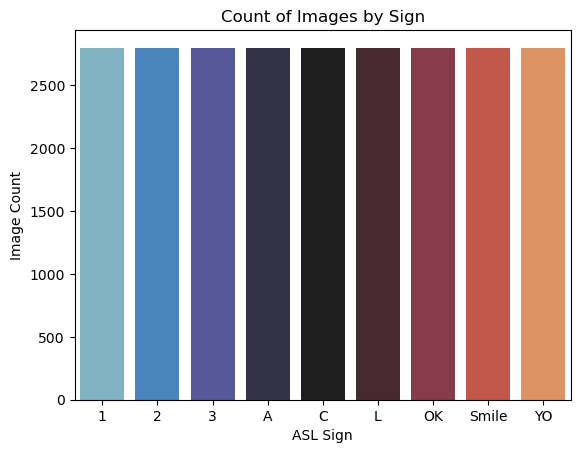

In [5]:
# visualize distribution of images by sign in dataset
sign_freq = df['label'].value_counts().reset_index().sort_values('label')
sns.barplot(sign_freq, x='label', y='count', palette='icefire')
plt.xlabel('ASL Sign')
plt.ylabel('Image Count')
plt.title('Count of Images by Sign')

In [6]:

# Split the dataset into training and testing sets (75% train, 25% test)
x_train, x_test0, y_train, y_test0 = train_test_split(df['file'], df['label'], test_size=0.25, random_state=42, stratify=df['label'])

# Further split the testing set into validation and testing sets (50% of the remaining 25%)
x_test, x_val, y_test, y_val = train_test_split(x_test0, y_test0, test_size=0.5, random_state=42, stratify=y_test0)

# Combine the file paths and labels into DataFrames for each set
train = pd.concat([x_train, y_train], axis=1).reset_index(drop=True)
test = pd.concat([x_test, y_test], axis=1).reset_index(drop=True)
val = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)

print(train['label'].dtype)
print(test['label'].dtype)
print(val['label'].dtype)

object
object
object


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the image size and batch size
image_size = 128
batchsize = 64

datagen_train = ImageDataGenerator(
    rescale=1.0/255,                # Normalize the training images
    rotation_range=20,              # Random rotation from -20 to 20 degrees
    width_shift_range=0.1,          # Random width shift
    height_shift_range=0.1,         # Random height shift
    shear_range=0.2,                # Random shear
    #zoom_range=0.01,                 # Random zoom
    horizontal_flip=True,           # Random horizontal flip
    vertical_flip=True,             # Random vertical flip
    fill_mode='nearest',            # Fill mode for newly created pixels
)
# Initialize the ImageDataGenerator for test and validation data
datagen_test = ImageDataGenerator(rescale=1.0/255)

# Load training data
train_data = datagen_train.flow_from_dataframe(
    dataframe=train,
    x_col='file',
    y_col='label',
    target_size=(image_size, image_size),
    color_mode='grayscale',  # Set color mode to grayscale
    shuffle=True,
    batch_size=batchsize,
    class_mode='categorical'
)

# Load test data
test_data = datagen_test.flow_from_dataframe(
    dataframe=test,
    x_col='file',
    y_col='label',
    target_size=(image_size, image_size),
    color_mode='grayscale',  # Set color mode to grayscale
    shuffle=False,
    batch_size=batchsize,
    class_mode='categorical'
)

# Load validation data
val_data = datagen_test.flow_from_dataframe(
    dataframe=val,
    x_col='file',
    y_col='label',
    target_size=(image_size, image_size),
    color_mode='grayscale',  # Set color mode to grayscale
    shuffle=False,
    batch_size=batchsize,
    class_mode='categorical'
)

Found 18900 validated image filenames belonging to 9 classes.
Found 3150 validated image filenames belonging to 9 classes.
Found 3150 validated image filenames belonging to 9 classes.


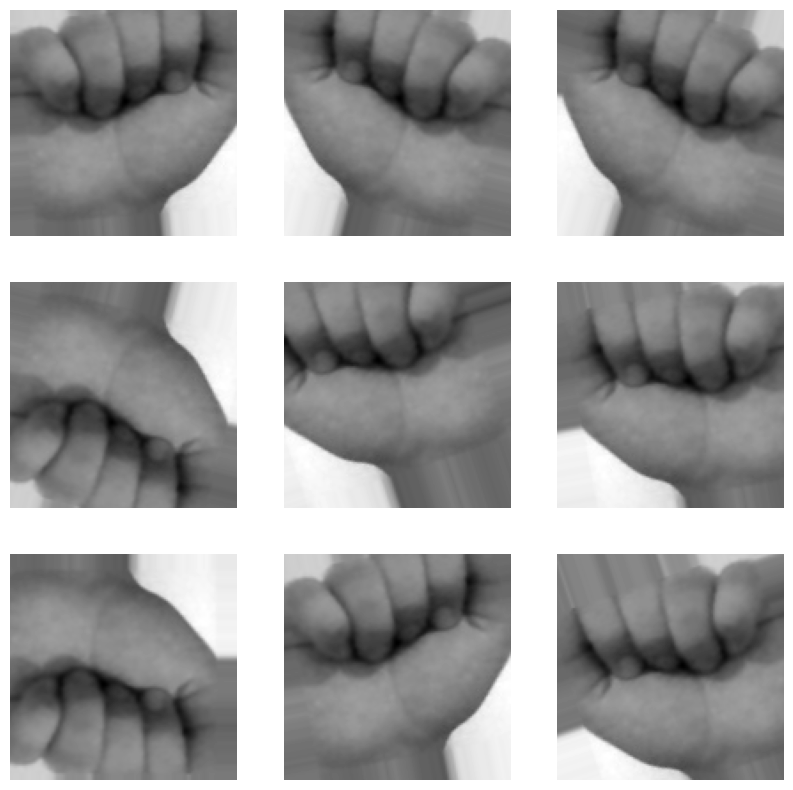

In [8]:

# Function to plot augmented images
def plot_augmented_images(datagen, sample_image, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # Apply augmentation
        augmented_image = datagen.random_transform(sample_image)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.squeeze(), cmap='gray')  # Assuming grayscale
        plt.axis("off")
    plt.show()

# Load a batch of images from the training dataset
for images, _ in train_data:
    # Take the first image from the batch
    sample_image = images[0]
    break

# Plot augmented images
plot_augmented_images(datagen_train, sample_image)

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras import regularizers
from keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam

# Initialize the model
model = Sequential()

# First convolutional layer with ReLU activation and L2 regularization
model.add(Conv2D(16, (3, 3), kernel_initializer=HeNormal(),
                 kernel_regularizer=regularizers.l2(0.02),  # L2 regularization
                 input_shape=(image_size, image_size, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.1))  # Dropout after activation

# Second convolutional layer with ReLU activation and L2 regularization
model.add(Conv2D(32, (3, 3), kernel_initializer=HeNormal(),
                 kernel_regularizer=regularizers.l2(0.02)))  # L2 regularization
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.1))  # Dropout after activation

# Third convolutional layer with ReLU activation and L2 regularization
model.add(Conv2D(64, (3, 3), kernel_initializer=HeNormal(),
                 kernel_regularizer=regularizers.l2(0.02)))  # L2 regularization
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.1))  # Dropout after activation

# Fourth convolutional layer with ReLU activation and L2 regularization
model.add(Conv2D(128, (3, 3), kernel_initializer=HeNormal(),
                 kernel_regularizer=regularizers.l2(0.02)))  # L2 regularization
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))  # Dropout after activation



# Flatten the output from the convolutional layers
model.add(Flatten())

# Fully connected layer with L2 regularization and dropout
model.add(Dense(256, activation='relu', kernel_initializer=HeNormal(),
                kernel_regularizer=regularizers.l2(0.02)))  # L2 regularization
model.add(Dropout(0.2))  # Dropout before output layer

# Output layer
model.add(Dense(9, activation='softmax'))

# Print the model summary
model.summary()


D:\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 126, 126, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,705,353 (6.51 MB)

 Trainable params: 1,705,353 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Initialize callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, restore_best_weights=True, verbose=1)
reducelr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)  # Monitor val_loss to reduce overfitting
checkpoint = ModelCheckpoint('my_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Compile the model with the Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Set the number of epochs
epochs = 30  # Increased epochs for better training


In [11]:
# Train the model
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[earlystop, reducelr, checkpoint]
)

Epoch 1/30


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.1534 - loss: 13.6053
Epoch 1: val_loss improved from inf to 4.08723, saving model to my_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 117s 385ms/step - accuracy: 0.1538 - loss: 13.5889 - val_accuracy: 0.5102 - val_loss: 4.0872 - learning_rate: 0.0010
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.6097 - loss: 3.4365
Epoch 2: val_loss improved from 4.08723 to 1.66007, saving model to my_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 122s 408ms/step - accuracy: 0.6100 - loss: 3.4346 - val_accuracy: 0.9676 - val_loss: 1.6601 - learning_rate: 0.0010
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8500 - loss: 1.7477
Epoch 3: val_loss improved from 1.66007 to 1.02761, saving model to my_model.keras
296/296 ━━━━━━━━━━━━━━━━━━━━ 118s 395ms/step - accuracy: 0.8501 - loss: 1.7471 - val_accuracy: 0.9768 - val_loss: 1.0276 - learning_rate: 0.0010
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy:

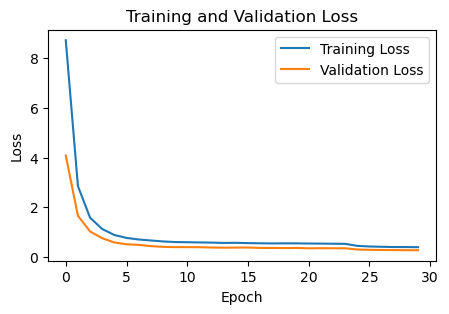

In [12]:

# Plotting the loss curve
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

In [13]:
# Predict on testing dataset and assess accuracy
probs = model.predict(test_data, verbose = 0)
y_pred = np.argmax(probs, axis = 1)
y_actual = test_data.labels

test_loss, test_accuracy = model.evaluate(test_data,verbose = 0)

print('Testing Accuracy:', test_accuracy)
print('Testing Loss:', test_loss, '\n')

correct = np.nonzero(y_pred==y_actual)[0]
incorrect = np.nonzero(y_pred!=y_actual)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0], '\n')

print(classification_report(y_pred, y_actual))

Testing Accuracy: 0.9987301826477051
Testing Loss: 0.272417813539505 

Correct predicted classes: 3146
Incorrect predicted classes: 4 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       1.00      0.99      0.99       352
           2       0.99      1.00      1.00       348
           3       1.00      1.00      1.00       351
           4       1.00      1.00      1.00       350
           5       1.00      1.00      1.00       350
           6       1.00      1.00      1.00       350
           7       1.00      1.00      1.00       349
           8       1.00      1.00      1.00       350

    accuracy                           1.00      3150
   macro avg       1.00      1.00      1.00      3150
weighted avg       1.00      1.00      1.00      3150



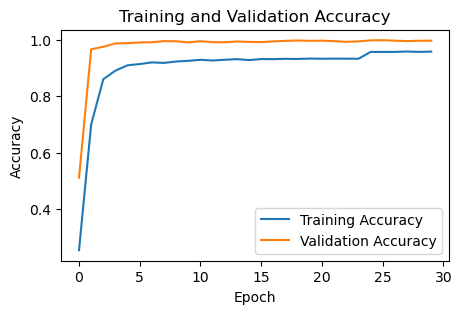

In [14]:
# Plotting the accuracy curve
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()


Text(0.5, 1.0, 'Confusion Matrix')

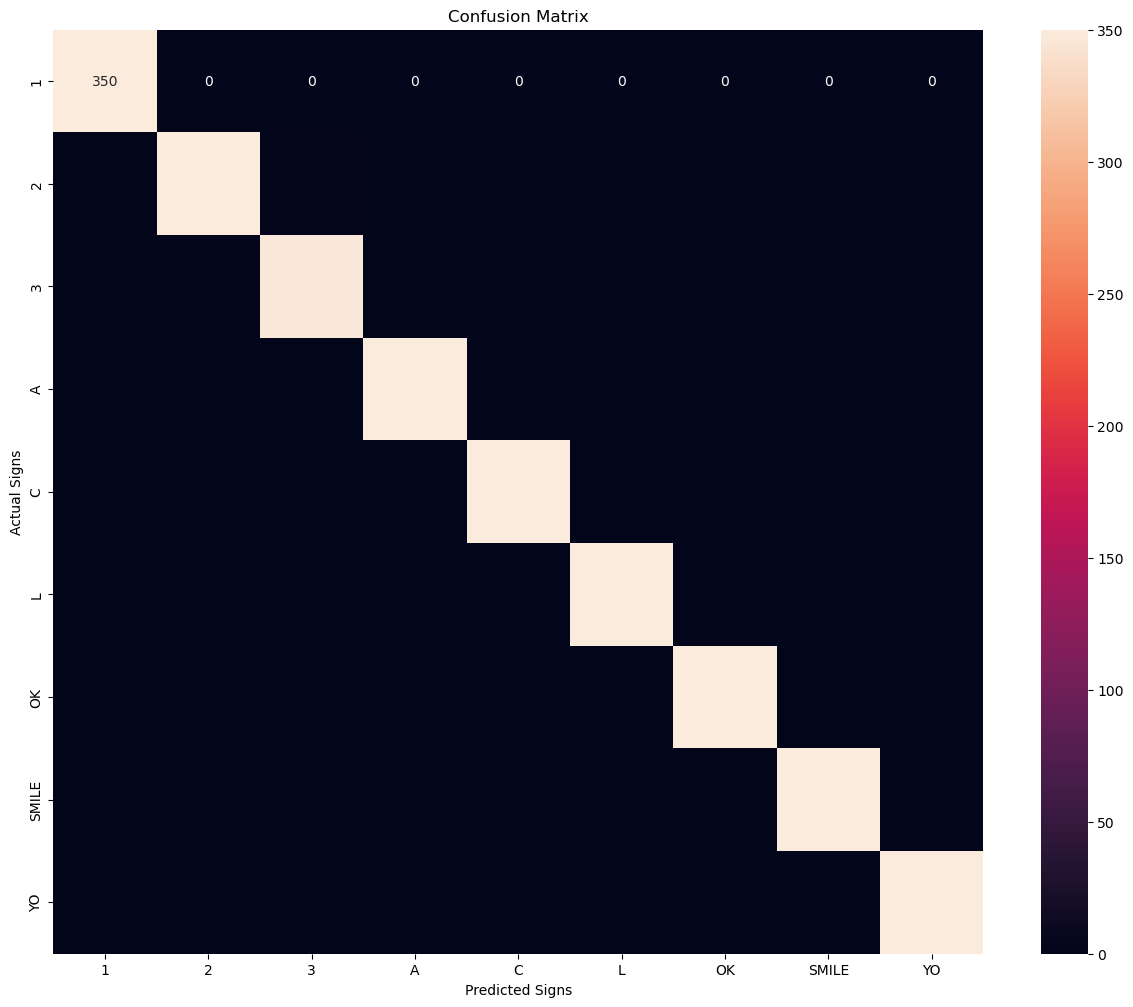

In [15]:
# Visualize confusion matrix of classifications
plt.figure(figsize = (15, 12))   
matrix = confusion_matrix(y_pred, y_actual)
matrixdf = pd.DataFrame(matrix, index=categories.values(), columns=categories.values())
sns.heatmap(matrixdf,annot=True,fmt='g')
plt.xlabel("Predicted Signs")
plt.ylabel("Actual Signs")
plt.title("Confusion Matrix")